# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pickle
import csv
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 8


get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


In [2]:
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

A histogram of number of examples in each class

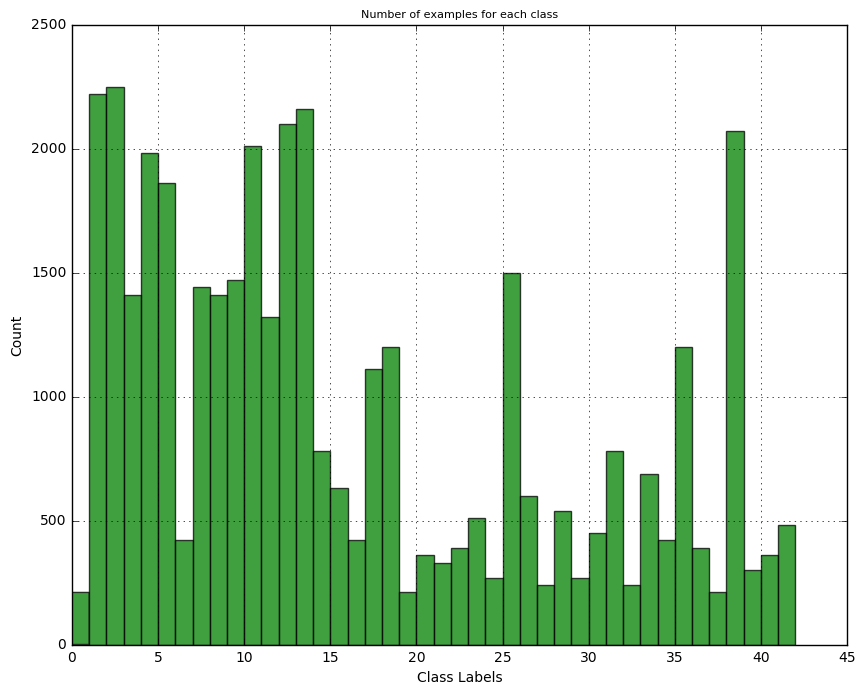

In [3]:
n, bins, patches = plt.hist(y_train, bins = np.max(y_train), facecolor='green', alpha=0.75)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Number of examples for each class")
plt.grid(True)
plt.show()

In [4]:
# Equalize and normalize images
for i, img in enumerate(X_train):
    # Apply histogram equalization on the Y channel. 
    tmp = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    tmp[:, :, 0] = cv2.equalizeHist(tmp[:, :, 0])
    X_train[i] = cv2.cvtColor(tmp, cv2.COLOR_YUV2RGB)
    
X_train = 0.1 + X_train * 0.8/255;


In [142]:
def plotLabels(X, y, labels):
    num_classes = 43
    for i in range(num_classes):
        idx = np.flatnonzero(y == i)
        idx = np.random.choice(idx, 1)
        plt.subplot(11, 4, i+1)
        plt.imshow(X[idx[0]])
        plt.axis('off')
        plt.title(labels[i])
        
def plotRandomLabelData(X, y, labels, samples_per_class = 10):    
    # Randomly pick a subset of sign to visualize
    cls_labels = np.random.choice(len(labels.keys()), 10, replace=False)
    num_classes = len(cls_labels)
    for ind, lbl in enumerate(cls_labels):
        idxs = np.flatnonzero(y == lbl)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + ind + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X[idx])
            plt.axis('off')
            if i == 0:
               plt.title(labels[lbl])
    plt.show()
    
sign_names = {}

with open('signnames.csv', 'r') as csvfile:
    signreader = csv.reader(csvfile, delimiter=',')
    next(signreader, None)
    for row in signreader:
        sign_names[int(row[0])] = row[1]

str_len = 8
short_signnames = {int(key) : (name[:str_len] + (name[str_len:] and '..')) for key, name in sign_names.items()}       

n_classes = len(sign_names)

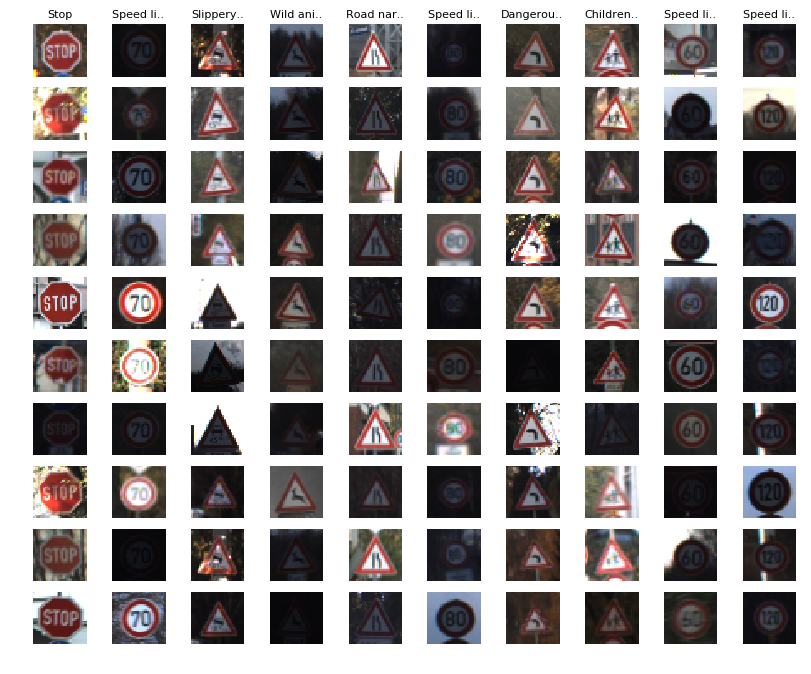

In [104]:
plotRandomLabelData(X_train, y_train, short_signnames)

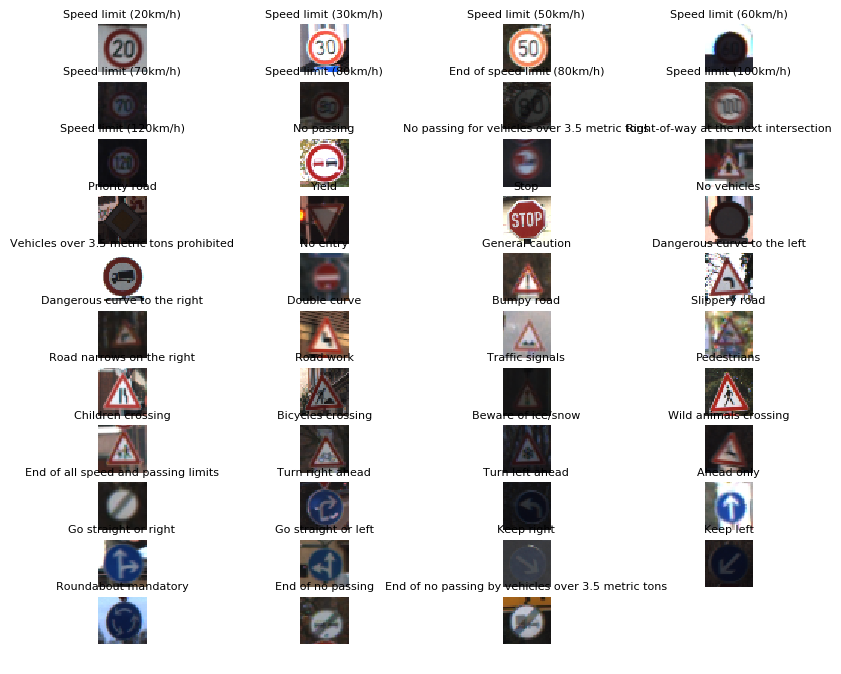

In [143]:
plotLabels(X_train, y_train, sign_names)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

All the training (and later testing) images were first converted to YUV color channel and then the histogram equalization was applied on the Y (brightness) channel. This ensures that signs are roughly uniformly lit. In the original data (see the plot of random sample above) many images are darker and barely visible. This transofmration fix this problem.

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [8]:
import cv2
# Function thanks to https://github.com/vxy10/ImageAugmentation

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,_ = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    return img

def augment_data(data, labels):
    train_X_new = []
    train_label_new = []

    for i, img in enumerate(data):
        # Randomly generate 5 perturbation for each image. 
        train_X_new.append(img)
        train_label_new.append(labels[i])
        
        for k in range(5):
            train_X_new.append(transform_image(img, 20, 10, 5))
            train_label_new.append(labels[i])
            
    return train_X_new, train_label_new
        

In [9]:
train_X_augmented = None
train_label_augmented = None

train_X_augmented, train_label_augmented = augment_data(X_train, y_train) 

train_X_augmented = np.array(train_X_augmented)
train_label_augmented = np.array(train_label_augmented)


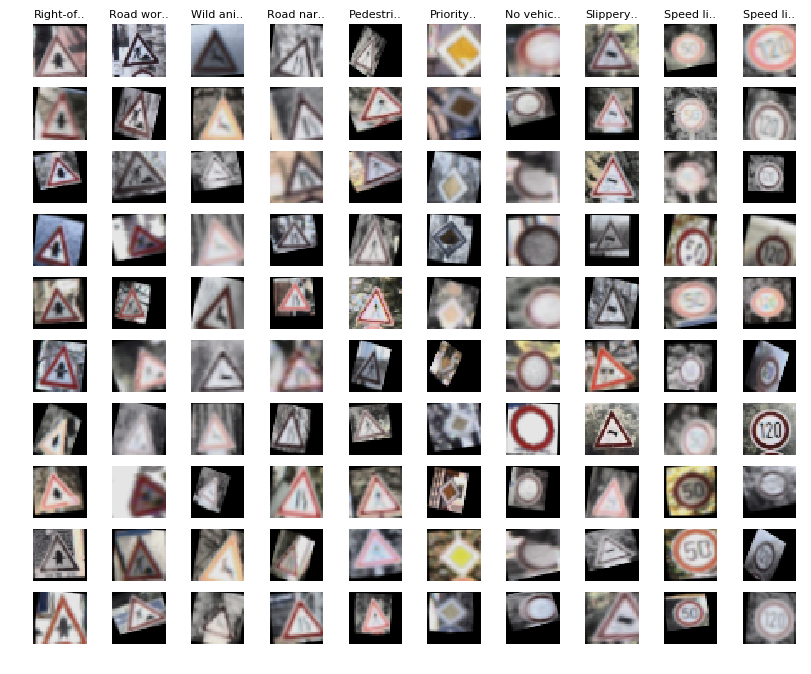

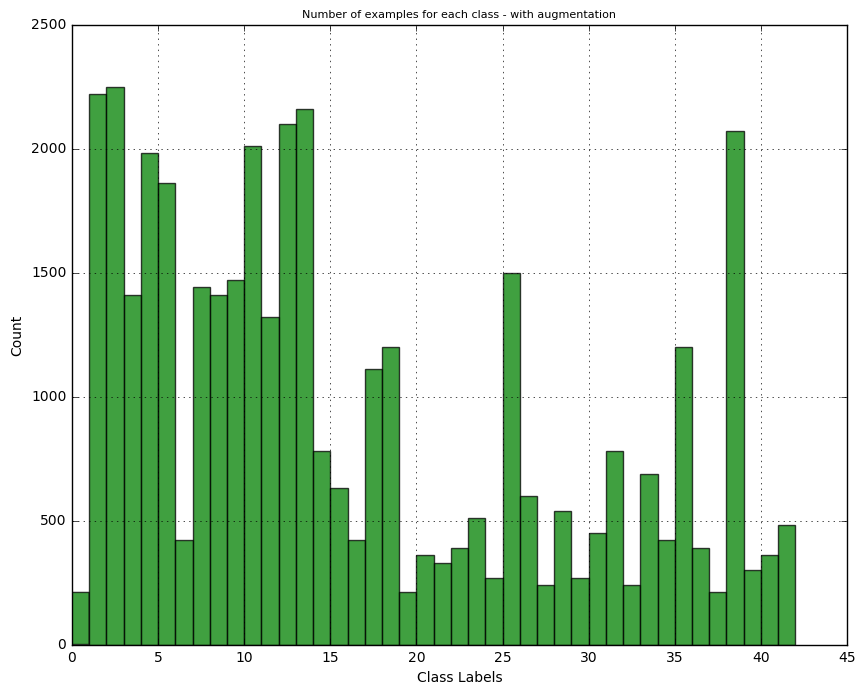

In [10]:
plotRandomLabelData(train_X_augmented, train_label_augmented, short_signnames)

# Save the data in new pickle file as check-point
data = {}
data['features'] = train_X_augmented
data['labels'] = train_label_augmented

with open('train_augmented.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

n, bins, patches = plt.hist(y_train, bins = np.max(y_train), facecolor='green', alpha=0.75)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Number of examples for each class - with augmentation")
plt.grid(True)
plt.show()

train_X_augmented = None
train_label_augmented = None

In [11]:
# Split the training data in training & validation. 

n_train = X_train.shape[0]
image_shape = X_train.shape[1:]
n_classes = 43

from sklearn.model_selection import train_test_split

X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train,
                                                                  y_train, 
                                                                  test_size=0.2, 
                                                                  random_state=40,
                                                                  stratify=y_train)

print ("Size of training examples", X_train.shape)
print ("Size of training split", X_train_split.shape)
print ("Size of validation ", X_valid.shape)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Size of training examples (39209, 32, 32, 3)
Size of training split (31367, 32, 32, 3)
Size of validation  (7842, 32, 32, 3)
Image data shape = (32, 32, 3)
Number of classes = 43


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The original training data was augmented by perturbing each image by randomly rotating, shearing and translation the original image. This was repeated ten times for each image. The rational behind this augmentaiton is to utilize the abilities of CNN to learn invance of the input features to their rotation, shear and translation position/angle. 


Testing data wasn't perturbed, however histogram equalization as described above was applied to each test image. 

Finally, to train our model, the training data was split into 80% training and 20% validation set. The split was done with stratification so the number of output classes follow roughly the same distribution in both the original training/validation. Additionall, the model was first trained on the orignial dataset with 80% of the training data and then later trained (fined tuned) on the augmented data. This was done to redue the training time required to train the model on a large dataset (10 times) of the original dataset. 

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The network is based on VGGNet as presented here (https://arxiv.org/pdf/1409.1556.pdf). The original network doesn't have dropout, but I added droput to the feed forward (fully connected) layers to avoid overfitting. Below is the diagram of the model followed by the actual implementation in Tensorflow.

In [13]:
#Implementation of a slightly modified VGGNet (https://arxiv.org/pdf/1409.1556.pdf)

from tensorflow.contrib.layers import flatten

mu = 0
sigma = 0.1

keep_prob = tf.placeholder(tf.float32)

layer_depth = {
    'layer_1' : 3,
    'layer_2' : 32,
    'layer_3' : 64,
    'layer_4' : 128,
    'fully_connected_1' : 1024,
    'fully_connected_2' : 1024,
    'fully_connected_3' : n_classes,
}

weights = {
    'layer_1' : tf.Variable(tf.truncated_normal([3, 3, 3, layer_depth['layer_1']], mean=mu, stddev=sigma)),
    'layer_2' : tf.Variable(tf.truncated_normal([3, 3, layer_depth['layer_1'], layer_depth['layer_2']], mean=mu, stddev=sigma)),
    'layer_3' : tf.Variable(tf.truncated_normal([3, 3, layer_depth['layer_2'], layer_depth['layer_3']], mean=mu, stddev=sigma)),
    'layer_4' : tf.Variable(tf.truncated_normal([3, 3, layer_depth['layer_3'], layer_depth['layer_4']], mean=mu, stddev=sigma)),
    'fully_connected_1' : tf.Variable(tf.truncated_normal([2048, layer_depth['fully_connected_1']], mean=mu, stddev=sigma)),
    'fully_connected_2' : tf.Variable(tf.truncated_normal([layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], mean=mu, stddev=sigma)),
    'fully_connected_3' : tf.Variable(tf.truncated_normal([layer_depth['fully_connected_2'], layer_depth['fully_connected_3']], mean=mu, stddev=sigma))
}

biases = {
    'layer_1' : tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2' : tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'layer_3' : tf.Variable(tf.zeros(layer_depth['layer_3'])),
    'layer_4' : tf.Variable(tf.zeros(layer_depth['layer_4'])),
    'fully_connected_1' : tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2' : tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'fully_connected_3' : tf.Variable(tf.zeros(layer_depth['fully_connected_3']))
}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def LeNet(x):

    # Layer 1: Convolutional. Input = 32x32x3. Output = 32x33x3
    conv = conv2d(x, weights['layer_1'], biases['layer_1'])

    # Layer 2: Convolutional. Input = 32x32x3. Output = 32x32x32
    conv = conv2d(conv, weights['layer_2'], biases['layer_2'])
    
    # Max Pooling. Input = 32x32x32. Output = 16x16x32
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

    # Layer 3: Convolutional. Input=16x16x64. 
    conv = conv2d(conv, weights['layer_3'], biases['layer_3'])

    # Max Pooling. Input = 16x16x64. Output = 8x8x64
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

    # Layer 4: Convolutional. Input=8x8x64. Output = 8x8x128
    conv = conv2d(conv, weights['layer_4'], biases['layer_4'])
    
    # Max Pooling. Input = 8x8*128. Output 4x4x128
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    
    conv = flatten(conv)

    # Fully connected layer 1. 
    fc1 = tf.add(tf.matmul(conv, weights['fully_connected_1']),biases['fully_connected_1'])
    fc1 = tf.nn.dropout(tf.nn.relu(fc1), keep_prob) #tf.nn.relu(fc1)

    # Fully connected layer 3.
    fc2 = tf.add(tf.matmul(fc1, weights['fully_connected_2']), biases['fully_connected_2'])
    fc2 = tf.nn.dropout(tf.nn.relu(fc2), keep_prob) #tf.nn.relu(fc2)

    # FC 3
    logits = tf.add(tf.matmul(fc2, weights['fully_connected_3']), biases['fully_connected_3'])
    
    return logits


In [14]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [15]:
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

y_pred = tf.argmax(logits, 1)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += loss
    return total_loss, total_accuracy / num_examples


In [16]:
def run_training_epocs(X_train, y_label, X_valid, y_valid, epochs=10, batch_size=128, restore=False):
    from sklearn.utils import shuffle

    X_train, y_label = shuffle(X_train, y_label)

    loss_epoch = []
    train_acc_epoch = []
    valid_acc_epoch = []

    with tf.Session() as sess:
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint('.'))
        else:
            sess.run(tf.global_variables_initializer())
        
        num_examples = len(X_train_split)

        print("Training...")
        print()
    
        for i in range(epochs):
            X_train, y_label = shuffle(X_train, y_label)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_label[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})

            training_loss, training_accuracy = evaluate(X_train, y_label, batch_size)
            valid_loss, validation_accuracy = evaluate(X_valid, y_valid, batch_size)
        
            loss_epoch.append(training_loss)
            train_acc_epoch.append(training_accuracy)
            valid_acc_epoch.append(validation_accuracy)
        
            print("EPOCH {} ...".format(i+1))
            print("Training loss = {:.3f}".format(training_loss))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
    
        saver.save(sess, 'vggnet-dropout-v2')
        print("Model saved")
        
        return loss_epoch, train_acc_epoch, valid_acc_epoch


In [17]:
# Train the network on the original (un-perturbed) data. 

loss, train_acc, valid_acc = run_training_epocs(X_train_split, 
                                                y_train_split, 
                                                X_valid, 
                                                y_valid, 
                                                epochs=50, 
                                                batch_size=512)


Training...

EPOCH 1 ...
Training loss = 136.673
Validation Accuracy = 0.384

EPOCH 2 ...
Training loss = 72.317
Validation Accuracy = 0.632

EPOCH 3 ...
Training loss = 45.347
Validation Accuracy = 0.759

EPOCH 4 ...
Training loss = 25.913
Validation Accuracy = 0.862

EPOCH 5 ...
Training loss = 14.816
Validation Accuracy = 0.914

EPOCH 6 ...
Training loss = 9.107
Validation Accuracy = 0.941

EPOCH 7 ...
Training loss = 5.823
Validation Accuracy = 0.954

EPOCH 8 ...
Training loss = 3.692
Validation Accuracy = 0.964

EPOCH 9 ...
Training loss = 2.560
Validation Accuracy = 0.970

EPOCH 10 ...
Training loss = 1.822
Validation Accuracy = 0.973

EPOCH 11 ...
Training loss = 1.101
Validation Accuracy = 0.977

EPOCH 12 ...
Training loss = 0.672
Validation Accuracy = 0.981

EPOCH 13 ...
Training loss = 0.635
Validation Accuracy = 0.981

EPOCH 14 ...
Training loss = 0.386
Validation Accuracy = 0.983

EPOCH 15 ...
Training loss = 0.366
Validation Accuracy = 0.984

EPOCH 16 ...
Training loss = 0

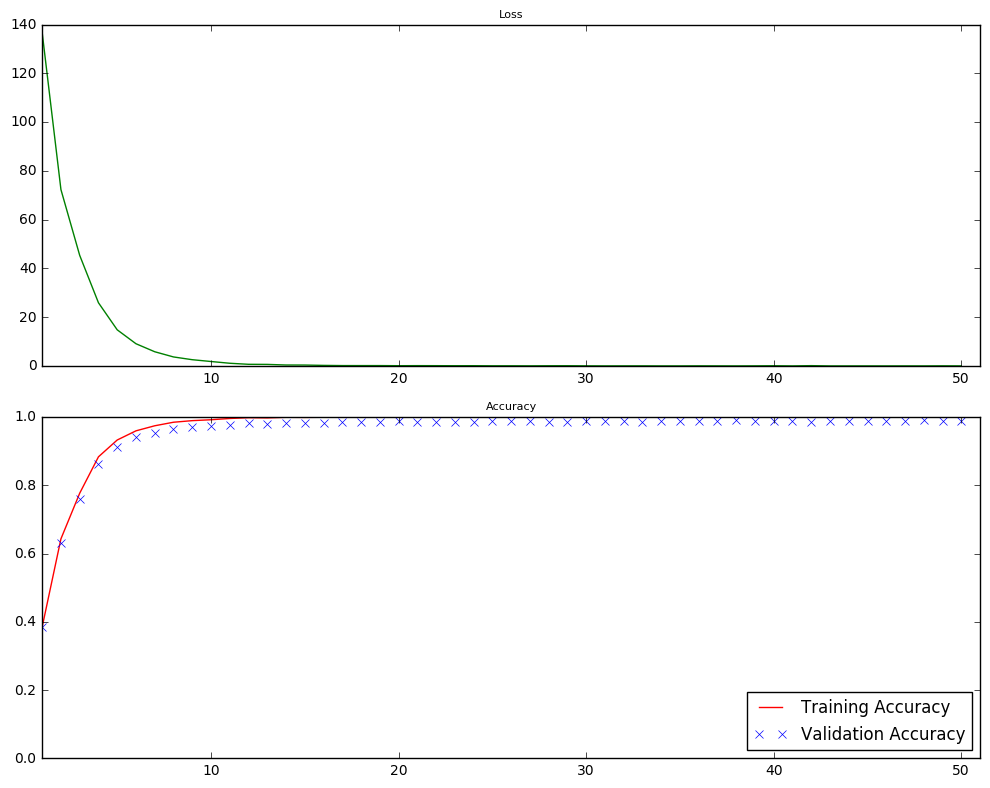

In [18]:
EPOCHS = 50

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(range(1, EPOCHS+1), loss, 'g')
loss_plot.set_xlim([1, EPOCHS+1])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(range(1, EPOCHS+1), train_acc, 'r', label='Training Accuracy')
acc_plot.plot(range(1, EPOCHS+1), valid_acc, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([1, EPOCHS+1])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()



In [19]:
# Load the augmented data for fine tuning the network.  
training_augmented_file = 'train_augmented.pickle'

with open(training_augmented_file, mode='rb') as f:
   train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

from sklearn.model_selection import train_test_split

X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train,
                                                                  y_train, 
                                                                  test_size=0.2, 
                                                                  random_state=40,
                                                                  stratify=y_train)

print ("Size of training examples", X_train.shape)
print ("Size of training split", X_train_split.shape)
print ("Size of validation ", X_valid.shape)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Size of training examples (235254, 32, 32, 3)
Size of training split (188203, 32, 32, 3)
Size of validation  (47051, 32, 32, 3)
Image data shape = (32, 32, 3)
Number of classes = 43


In [20]:

# Fine tune the network on perturbed data. 
loss, train_acc, valid_acc = run_training_epocs(X_train_split, 
                                                y_train_split, 
                                                X_valid, 
                                                y_valid, 
                                                epochs=50, 
                                                batch_size=1024,
                                                restore=True)


Training...

EPOCH 1 ...
Training loss = 66.638
Validation Accuracy = 0.877

EPOCH 2 ...
Training loss = 35.782
Validation Accuracy = 0.924

EPOCH 3 ...
Training loss = 25.134
Validation Accuracy = 0.936

EPOCH 4 ...
Training loss = 16.700
Validation Accuracy = 0.950

EPOCH 5 ...
Training loss = 11.777
Validation Accuracy = 0.958

EPOCH 6 ...
Training loss = 8.939
Validation Accuracy = 0.962

EPOCH 7 ...
Training loss = 7.329
Validation Accuracy = 0.962

EPOCH 8 ...
Training loss = 5.008
Validation Accuracy = 0.967

EPOCH 9 ...
Training loss = 3.805
Validation Accuracy = 0.970

EPOCH 10 ...
Training loss = 3.254
Validation Accuracy = 0.970

EPOCH 11 ...
Training loss = 2.709
Validation Accuracy = 0.971

EPOCH 12 ...
Training loss = 2.398
Validation Accuracy = 0.971

EPOCH 13 ...
Training loss = 1.697
Validation Accuracy = 0.973

EPOCH 14 ...
Training loss = 1.575
Validation Accuracy = 0.974

EPOCH 15 ...
Training loss = 1.787
Validation Accuracy = 0.972

EPOCH 16 ...
Training loss = 0.

In [21]:
import sklearn as sk

BATCH_SIZE=2048

p = 0.0
r = 0.0
f = 0.0
c = 0

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))   
    for offset in range(0, len(y_valid), BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_valid[offset:end], y_valid[offset:end]
        y_prediction = sess.run(y_pred, feed_dict={x:batch_x, y:batch_y, keep_prob : 1.0})
    
        
        p = p + sk.metrics.precision_score(batch_y, y_prediction, average='weighted')
        
        r = r + sk.metrics.recall_score(batch_y, y_prediction, average='weighted')
        f = f + sk.metrics.f1_score(batch_y, y_prediction, average='weighted')
        
        c = c + 1
    
p = p / c
r = r / c
f = f / c

print (p, r, f)

0.978894565293 0.978317588298 0.97827385364


In [22]:
# Moment of truth: How well our model perfom on the test data. 
testing_file = 'test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

test_X, y_test = test['features'], test['labels']


for i, img in enumerate(test_X):
    tmp = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    tmp[:, :, 0] = cv2.equalizeHist(tmp[:, :, 0])
    img = cv2.cvtColor(tmp, cv2.COLOR_YUV2RGB)
    test_X[i] = img

test_X = 0.1 + test_X * 0.8/255

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    loss, test_accuracy = evaluate(test_X, y_test, batch_size=512)
    print ("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.956


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The optimizer used was Adam optimizer for its ability to dynamically adjust the learning rate. The batch size, epochs and learning rate were decided based on the systematic exploration of these parameters. Here is the rough sketch of these experiments:

a) First, The batch size was fixed to 256 and epochs to 30
b) We let the network training with a learning rate starting at 0.1 and decreasing it manually as the loss is plateaued. 
c) At the end of the run model is saved on the disk. 
c) If the model is still improving, we can run it for more EPOCHS by first restoring the saved model (instead of reinitializing the weights).

The best results across all experiments were 

batch_size = 256 or 512 (Finally picked 512)
learning rate = 0.001 (lower rates were very slow and higher rates gave very poor results)
EPOCHS = manually set in the increment of 30, until the loss is plateaued. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

As with the case in many deep learning problem, you start with an existing network and improve upon it. I tried two different networks 

a) LeNet (from the class)
b) VGGNet+dropout (https://arxiv.org/pdf/1409.1556.pdf)

**LeNet** Tried different variation of the dataset and it performed well on the original dataset but with the augmented dataset the results were rather poor. 

**VGGNet+droput** My final solution is based on this network. There are different reasons to pick this architecture.(i) The network is known to perform really well with the image data as apparent from the fact that it was a runner up of the  ILSVRC 2014 copmetition. (ii) The depth and memory requirement for the network was just right for the GPU available to me for training (iii) After doing a lot of fine tuning of LeNet, I wasn't getting any major performance gain so it was time to try a more deeper network. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

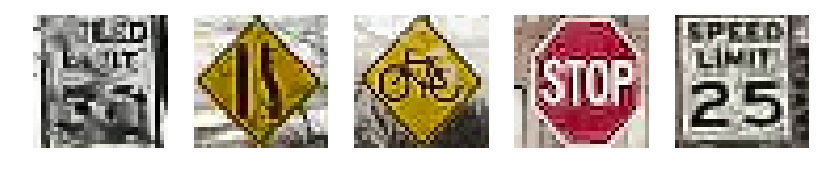

In [34]:
import cv2 as mpimg

image_dir = 'traffic_signs/'

from os import listdir
files = [f for f in listdir(image_dir)]

captured_images = []

for i, file in enumerate(files):
    img = mpimg.imread("%s/%s"%(image_dir, file))    
    img = cv2.resize(img, (32, 32))
    tmp = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    tmp[:, :, 0] = cv2.equalizeHist(tmp[:, :, 0])
    img = cv2.cvtColor(tmp, cv2.COLOR_YUV2RGB)

    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(img)
    captured_images.append(img)

captured_images = np.array(captured_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [35]:
# Pre-processing
captured_images = 0.1 + captured_images * 0.8/255


[40 12 14 14 23]


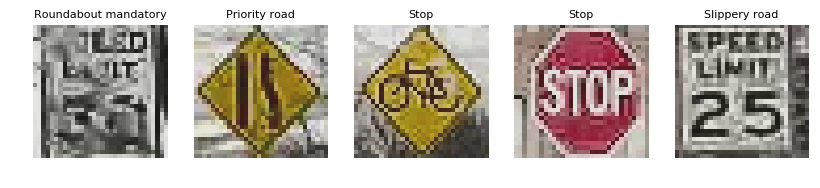

In [37]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y = sess.run(y_pred, feed_dict={x: captured_images, keep_prob:1.0})

print (y)
for i, img in enumerate(captured_images):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.title(sign_names["%s"%y[i]])
    plt.imshow(img)


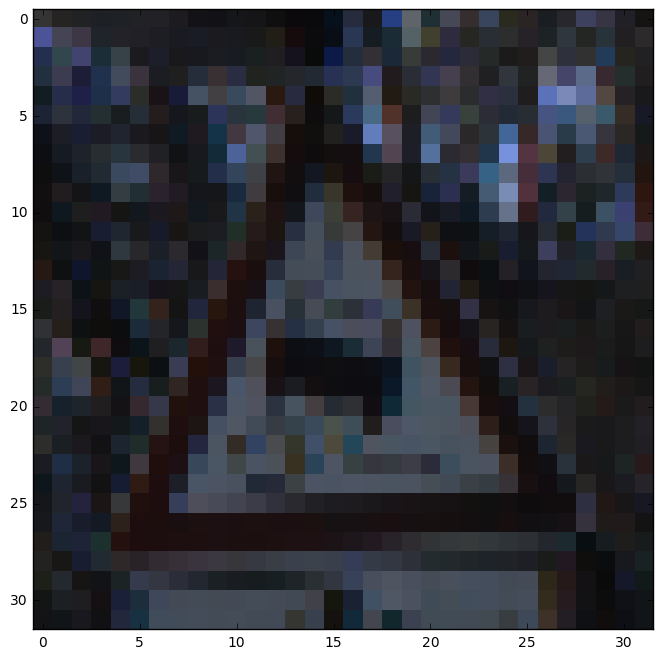

In [57]:
training_file = 'train.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

idxs = np.flatnonzero(y_train == 23)
idxs = np.random.choice(idxs, 1, replace=False)
plt.imshow(X_train[idxs[0]])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

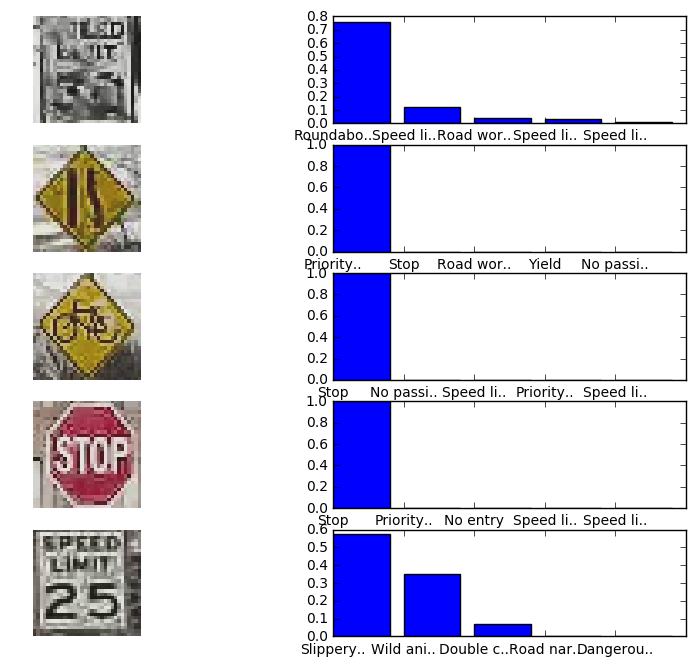

In [120]:
# Softmax probabilites. 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: captured_images, keep_prob:1.0})
    
k = 1
for i, img in enumerate(captured_images):
    plt.subplot(5, 2, k)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(5, 2, k+1)
    lbls = [short_signnames[x] for x in y.indices[i]]
    plt.bar(range(5), y.values[i])
    plt.xticks(range(5), lbls)
    k = k +  2


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.